In [79]:
import os
from datetime import datetime
import pandas as pd

# Arial font
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

raw_data_path = '/Users/rajivmovva/data/instagram/nba/'

In [68]:
'''
The directory contains lots of .txt files of the format:
    '2023-11-13_04-43-48_UTC.txt'

Get every file matching this format and read the contents
into a dataframe with two columns:
    1. 'date' - Date + time as datetime object
    2. 'text' - The content of the text file
'''

date_threshold = datetime(2013, 10, 23)

boilerplate_phrases = [
    'Watch all games FREE on the NBA App with your NBA ID!',
    '<Watch LIVE on the NBA App',
]
def parse_caption(caption):
    '''
    Replace all whitespace characters with spaces.

    Remove random NBA fillertext in the caption, like:

    'Watch all games FREE on the NBA App with your NBA ID!'
    '<Watch LIVE on the NBA App • link in bio>'

    Find phrases like this and remove this text + all text after it.
    '''
    caption = ' '.join(caption.split())

    # Only include the caption text before the first of these phrases
    
    for phrase in boilerplate_phrases:
        if phrase in caption:
            caption = caption.split(phrase)[0]
            break

    return caption


df_data = {'date': [], 'caption': [], 'likes': [], 'comments': []}
for file in os.listdir(raw_data_path):
    if not file.endswith('.txt'):
        continue

    datetime_str = file.split('_')[0] + '_' + file.split('_')[1]
    dt = datetime.strptime(datetime_str, '%Y-%m-%d_%H-%M-%S')
    if dt < date_threshold:
        continue

    with open(raw_data_path + file, 'r') as f:
        text = f.read()
        caption, likes, comments = text.split('/////')
    df_data['date'].append(dt)
    
    caption = caption.split('Caption: ')[1]
    likes = likes.split('Likes: ')[1]
    comments = comments.split('Comments: ')[1]
    
    df_data['caption'].append(parse_caption(caption))
    df_data['likes'].append(int(likes))
    df_data['comments'].append(int(comments))

df = pd.DataFrame(df_data).sort_values(by='date').reset_index(drop=True)
# Controversial posts have high comment/like ratio
df['comments:likes'] = df['comments'] / df['likes']

print(df.shape)
display(df.head())

(15357, 5)


,date,caption,likes,comments,comments:likes
0,2022-10-18 01:34:12,@CP3’s fits through the years👔👀 Check out more...,254490,1255,0.004931
1,2022-10-18 02:03:45,👀 This week’s NBA App Power Rankings heading i...,454745,2632,0.005788
2,2022-10-18 04:47:41,The NBA is back and so is Zion Williamson 😈 Th...,172722,305,0.001766
3,2022-10-18 14:03:54,"Happy Birthday Brittney Griner, we will not fo...",188224,4802,0.025512
4,2022-10-18 14:33:42,The _______ will win the 2023 🏆 #KiaTipOff22 b...,313453,10861,0.034650


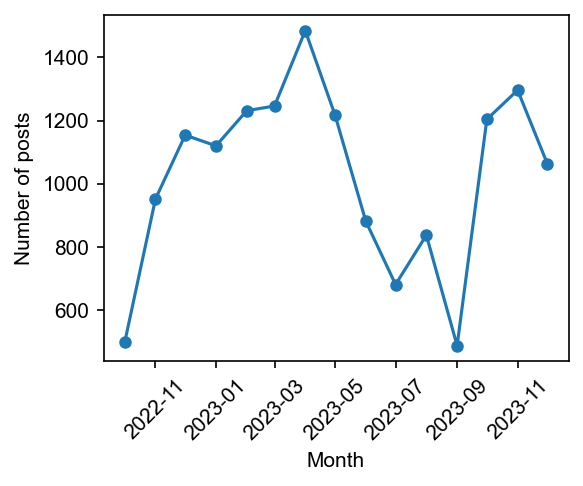

In [85]:
# Display linegraph of posts per month
new_df = df.copy()
new_df['month'] = df['date'].apply(lambda x: x.month)
new_df['year'] = df['date'].apply(lambda x: x.year)
new_df['month_year'] = new_df['month'].astype(str) + '-' + new_df['year'].astype(str)
new_df['month_year'] = pd.to_datetime(new_df['month_year'], format='%m-%Y')
counts_by_date = new_df.groupby('month_year').count()['date']

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(counts_by_date, marker='o', markersize=5)#, linewidth=1)
plt.xlabel('Month')
plt.ylabel('Number of posts')
# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [87]:
'''
Run spaCy entity extraction on each Instagram caption.

Track all entities as a new column in the dataframe.
But only keep entities with the following labels: {PERSON, GPE}
'''
def extract_entities_batch(captions, include_labels=set(['PERSON', 'GPE'])):
    # Load spaCy English model
    nlp = spacy.load("en_core_web_sm")

    # Process captions in batch
    docs = list(nlp.pipe(captions))

    # Extract entities for each document in the batch
    entities_batch = [
        [(ent.text, ent.label_) for ent in doc.ents]
        for doc in docs
    ]

    # Only retain entities with the specified labels
    entities_batch = [
        [ent[0] for ent in entities if ent[1] in include_labels]
        for entities in entities_batch
    ]

    return entities_batch

df['spaCy_entities'] = extract_entities_batch(df['caption'])


In [88]:
# Most common Spacy entities
from collections import Counter
entities = [ent for ents in df['spaCy_entities'] for ent in ents]
display(Counter(entities).most_common(20))

[('NBAPlayoffs', 477),
 ('@googlepixel_us', 185),
 ('@wemby', 141),
 ('LeBron', 130),
 ('LA', 112),
 ('Las Vegas', 111),
 ('NBAXmas', 108),
 ('@tyresehaliburton', 105),
 ('NBAPreseason', 104),
 ('NBAAllStar', 101),
 ('KD', 98),
 ('Luka', 90),
 ('KiaTipOff22', 89),
 ('ATTPlayIn', 89),
 ('NBAVault', 83),
 ('📸', 81),
 ('NBACelebRow', 76),
 ('@shai', 70),
 ('Joker', 68),
 ('Steph', 64)]

In [42]:
import spacy

def extract_entities_batch(captions):
    # Load spaCy English model
    nlp = spacy.load("en_core_web_sm")

    # Process captions in batch
    docs = list(nlp.pipe(captions))

    # Extract entities for each document in the batch
    entities_batch = [
        [(ent.text, ent.label_) for ent in doc.ents]
        for doc in docs
    ]

    return entities_batch

# Example list of Instagram captions
instagram_captions = df['text'].tolist()[1500:1600]

# Extract entities for the entire batch
result_batch = extract_entities_batch(instagram_captions)

# Print the extracted entities for each caption in the batch
for i, entities in enumerate(result_batch):
    print(f"Entities for caption {i + 1}:")
    print(instagram_captions[i], '\n')
    for entity, label in entities:
        print(f"{entity}: {label}")
    print()


Entities for caption 1:
@theanthonyedwards_ ELEVATES for the big rejection! 🏆 NBA In-Season Tournament 🏀 West Group C action on NBA App 

ELEVATES: PERSON
NBA: ORG
West Group C: ORG
NBA App: ORG

Entities for caption 2:
That’s tough, @tyresehaliburton 😤 🏆 NBA In-Season Tournament 🏀 East Group A action on NBA App 

@tyresehaliburton 😤 🏆: PERSON
NBA: ORG
East Group: ORG
NBA App: ORG

Entities for caption 3:
Friday night vibes are high! 

Friday night: TIME

Entities for caption 4:
@fredvanvleet to @jalen ‼️ 🏆 NBA In-Season Tournament 🏀 West Group B action on NBA App 

@jalen ‼️ 🏆: PERSON
NBA: ORG
West Group: ORG
NBA App: ORG

Entities for caption 5:
Pregame half-court shot with Dad ❤️💙 

half: CARDINAL

Entities for caption 6:
@nyknicks clutch buckets LATE on ESPN! 

ESPN: ORG

Entities for caption 7:
@andrew.nembhard finds @brucebrown in transition! 🏆 NBA In-Season Tournament 🏀 East Group A action on the NBA App 

NBA: ORG
East Group: ORG

Entities for caption 8:
our PA announcer Troy P